# **Прогноз температуры расплава**

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. з
Задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

### Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные хранятся в базе данных PostgreSQL. 

Она состоит из нескольких таблиц:

- steel.data_arc — данные об электродах;
- steel.data_bulk — данные об объёме сыпучих материалов;
- steel.data_bulk_time — данные о времени подачи сыпучих материалов;
- steel.data_gas — данные о продувке сплава газом;
- steel.data_temp — данные об измерениях температуры;
- steel.data_wire — данные об объёме проволочных материалов;
- steel.data_wire_time — данные о времени подачи проволочных материалов.

Таблица steel.data_arc
- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

Таблица steel.data_bulk
- key — номер партии;
- Bulk1 … Bulk15 — объём подаваемого материала.

Таблица steel.data_bulk_time
- key — номер партии;
- Bulk1 … Bulk15 — время подачи материала.

Таблица steel.data_gas
- key — номер партии;
- gas — объём подаваемого газа.

Таблица steel.data_temp
- key — номер партии;
- MesaureTime — время замера;
- Temperature — значение температуры.

Таблица steel.data_wire
- key — номер партии;
- Wire1 … Wire15 — объём подаваемых проволочных материалов.

Таблица steel.data_wire_time
- key — номер партии;
- Wire1 … Wire15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Рисунок 1. Общая схема установки печь-ковш**

1. Сталеразливочный ковш;
2. Трайб-аппарат; 
3. Свод агрегата ковш-печь; 
4. Графитированные электроды; 
5. Воронка подачи сыпучих материалов;
6. Аварийная фурма.
- (без нумерации) снизу показано сопло подачи инертного газа 

### Загрузка данных

In [66]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import phik
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from IPython.display import display, HTML
import ipywidgets as widgets
from sklearn.metrics import mean_absolute_error
import time
from sklearn.dummy import DummyRegressor
pd.set_option('display.max_columns', None)

In [2]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])
engine = create_engine(connection_string)

def read_sql(query):
    return pd.read_sql_query(query, con=engine)

RANDOMSTATE = 60624

In [3]:
#таблицы по условию задачи
tables = [
'data_arc',
'data_bulk',
'data_bulk_time',
'data_gas',
'data_temp',
'data_wire',
'data_wire_time']
for table in tables:
    print(read_sql(f"SELECT column_name, data_type FROM information_schema.columns WHERE table_name = '{table}'"))

     column_name               data_type
0            key                 integer
1      BeginHeat  time without time zone
2        EndHeat  time without time zone
3    ActivePower                 numeric
4  ReactivePower                 numeric
   column_name data_type
0          key   integer
1       Bulk 1   numeric
2       Bulk 2   numeric
3       Bulk 3   numeric
4       Bulk 4   numeric
5       Bulk 5   numeric
6       Bulk 6   numeric
7       Bulk 7   numeric
8       Bulk 8   numeric
9       Bulk 9   numeric
10     Bulk 10   numeric
11     Bulk 11   numeric
12     Bulk 12   numeric
13     Bulk 13   numeric
14     Bulk 14   numeric
15     Bulk 15   numeric
   column_name               data_type
0          key                 integer
1       Bulk 1  time without time zone
2       Bulk 2  time without time zone
3       Bulk 3  time without time zone
4       Bulk 4  time without time zone
5       Bulk 5  time without time zone
6       Bulk 6  time without time zone
7       Bulk 7  t

In [4]:
print(read_sql(f"SELECT COUNT(*) FROM information_schema.columns"))

for table in tables:
    print(read_sql(f"SELECT COUNT(*) FROM information_schema.columns WHERE table_name = '{table}'"))

   count
0   1901
   count
0      5
   count
0     16
   count
0     16
   count
0      2
   count
0      3
   count
0     10
   count
0     10


**Выводы:**
- База данных имеет множество таблиц, которые не нужны при выполнении данной задачи.
- Типы данных соответствуют значениям.

### Исследовательский анализ данных

### data_arc

In [5]:
df = read_sql('SELECT * FROM steel.data_arc')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


In [6]:
df.isna().sum().sum(), df.duplicated().sum()

(0, 0)

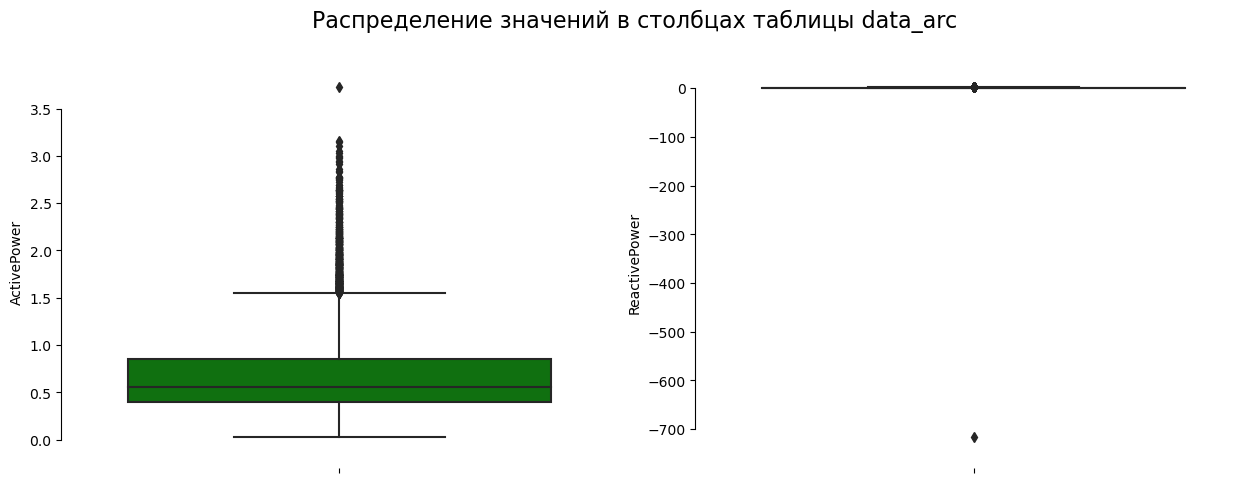

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(y='ActivePower', data=df, ax=ax[0], color='green')
sns.boxplot(y='ReactivePower', data=df, ax=ax[1], color='green')
sns.despine(offset=10, trim=True)
fig.suptitle('Распределение значений в столбцах таблицы data_arc ', y=1.0, fontsize=16);

In [8]:
shape_first = df.shape[0]
df = df[df['ReactivePower'] > 0]
print('Удалено строк:',shape_first - df.shape[0])

Удалено строк: 1


In [9]:
df.describe()

,key,ActivePower,ReactivePower
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


Я добавлю новые признаки: TimeHeat - он будет показывать время нагрева, следовательно EndHeat и BeginHeat можно будет удалить; heat_times - сколько раз нагревали.

In [10]:
df[['ActivePower', 'ReactivePower']].corr()

,ActivePower,ReactivePower
ActivePower,1.000000,0.963182
ReactivePower,0.963182,1.000000


Из-за слишком высокой корреляции я посчитаю общую мощность.

In [11]:
print('Итоговый запрос для данной таблицы:')
data_arc = '''
SELECT key, CAST(AVG(time) as time) as heating_time, SUM("ActivePower") as "Power", 
AVG("heat_times") as "heat_times"
FROM (SELECT *, COUNT(key) OVER (PARTITION BY key) as heat_times
FROM (SELECT key, CAST(CAST("EndHeat" as time) - CAST("BeginHeat" as time) as time), "ActivePower", "ReactivePower"
FROM steel.data_arc 
WHERE "ReactivePower" > 0) as data_arc) as data_arc
GROUP BY key
'''

read_sql(data_arc)

Итоговый запрос для данной таблицы:


,key,heating_time,Power,heat_times
0,1,00:03:39.600000,4.878147,5.0
1,2,00:03:22.750000,3.052598,4.0
2,3,00:02:11,2.525882,5.0
3,4,00:03:05.250000,3.209250,4.0
4,5,00:03:37.250000,3.347173,4.0
...,...,...,...,...
3209,3237,00:03:01.800000,3.932467,5.0
3210,3238,00:03:02,2.106529,3.0
3211,3239,00:02:32,4.666754,8.0
3212,3240,00:02:47.800000,2.984083,5.0


In [12]:
pivot = '''
SELECT *
FROM (SELECT key, CAST(CAST("EndHeat" as time) - CAST("BeginHeat" as time) as time), "ActivePower", "ReactivePower"
FROM steel.data_arc 
WHERE ("ActivePower" < 1.5) AND ("ReactivePower" > -50)) as data_arc
WHERE "time" > '12:00:00' 
'''
read_sql(pivot)

,key,time,ActivePower,ReactivePower


Нет строк, в которых больше 12:00:00 разница во времени.

### data_bulk

In [13]:
df = read_sql('SELECT * FROM steel.data_bulk')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Так как у меня нет точных данных о том, что за материал Bulk 1, Bulk 2 ... Bulk 15, могу сделать вывод, что на месте пропусков должны стоять 0. Так как посмотрев на данные я увидел, что в каких-то партиях состав один, в других - другой, следовательно, скорее всего NaN означает, что данный Bulk не добавляли в эту партию. Заменю на нули.

In [14]:
df.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

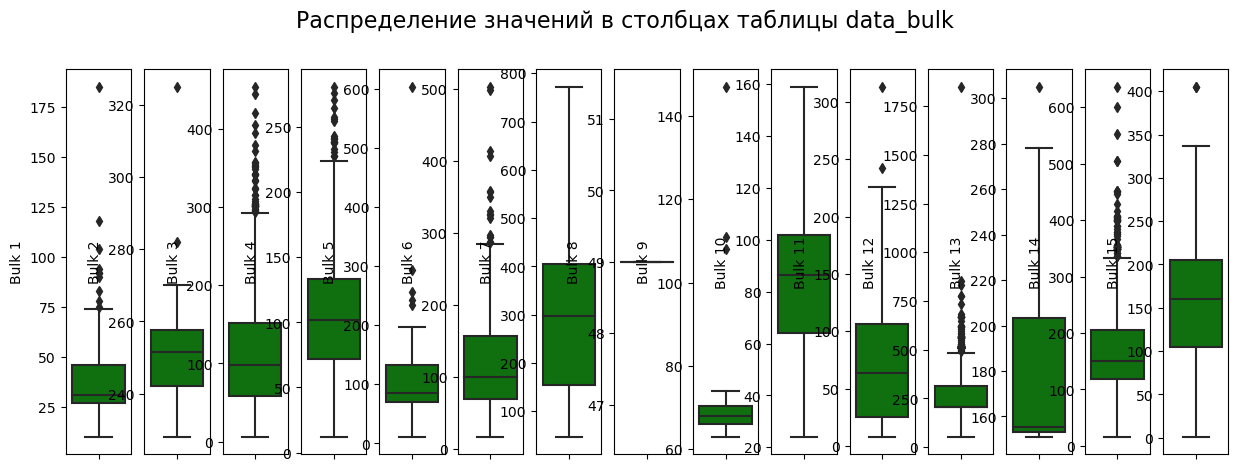

In [15]:
fig, ax = plt.subplots(1, 15, figsize=(15, 5))
columns = df.columns[1:16]
for i in range(1,16):
    column = columns[i-1]
    sns.boxplot(y=f'{column}', data=df, ax=ax[i-1], color='green')
fig.suptitle('Распределение значений в столбцах таблицы data_bulk ', y=1.0, fontsize=16);

Много выбросов, но удалю только несколько критических, тк данных совсем мало

In [16]:
df.corr() > 0.8

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
Bulk 2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
Bulk 5,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
Bulk 6,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
Bulk 7,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
Bulk 8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 9,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False


У 7 и 2 высокая корреляция, удалю элемент под номером 2.

In [17]:
print('Итоговый запрос для данной таблицы:')
data_bulk = '''
SELECT *
FROM (SELECT key,
        COALESCE("Bulk 1", 0) as "Bulk 1",
        COALESCE("Bulk 3", 0) as "Bulk 3",
        COALESCE("Bulk 4", 0) as "Bulk 4",
        COALESCE("Bulk 5", 0) as "Bulk 5",
        COALESCE("Bulk 6", 0) as "Bulk 6",
        COALESCE("Bulk 7", 0) as "Bulk 7",
        COALESCE("Bulk 8", 0) as "Bulk 8",
        COALESCE("Bulk 9", 0) as "Bulk 9",
        COALESCE("Bulk 10", 0) as "Bulk 10",
        COALESCE("Bulk 11", 0) as "Bulk 11",
        COALESCE("Bulk 12", 0) as "Bulk 12",
        COALESCE("Bulk 13", 0) as "Bulk 13",
        COALESCE("Bulk 14", 0) as "Bulk 14",
        COALESCE("Bulk 15", 0) as "Bulk 15"
FROM steel.data_bulk) as data_bulk
WHERE (
("Bulk 1" <> 0.0) or ("Bulk 3" <> 0.0) or ("Bulk 4" <> 0.0) or ("Bulk 5" <> 0.0) or 
("Bulk 6" <> 0.0) or ("Bulk 7" <> 0.0) or ("Bulk 8" <> 0.0) or ("Bulk 9" <> 0.0) or ("Bulk 10" <> 0.0) or 
("Bulk 11" <> 0.0) or ("Bulk 12" <> 0.0) or ("Bulk 13" <> 0.0) or ("Bulk 14" <> 0.0) or ("Bulk 15" <> 0.0))
'''
read_sql(data_bulk)

Итоговый запрос для данной таблицы:


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


### data_bulk_time

In [18]:
df = read_sql('SELECT * FROM steel.data_bulk_time')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


Можно заметить, что пропуски в этих таблицах совпадают с пропусками в предыдущей, следовательно, гипотеза о том, что пропущенные вещества просто не добавляли становится еще более убедительной.

In [19]:
print('Итоговый запрос для данной таблицы:')
data_bulk_time = '''
SELECT key,
        COALESCE("Bulk 1", '00:00:00') as "Bulk 1",
        COALESCE("Bulk 2", '00:00:00') as "Bulk 2",
        COALESCE("Bulk 3", '00:00:00') as "Bulk 3",
        COALESCE("Bulk 4", '00:00:00') as "Bulk 4",
        COALESCE("Bulk 5", '00:00:00') as "Bulk 5",
        COALESCE("Bulk 6", '00:00:00') as "Bulk 6",
        COALESCE("Bulk 7", '00:00:00') as "Bulk 7",
        COALESCE("Bulk 8", '00:00:00') as "Bulk 8",
        COALESCE("Bulk 9", '00:00:00') as "Bulk 9",
        COALESCE("Bulk 10", '00:00:00') as "Bulk 10",
        COALESCE("Bulk 11", '00:00:00') as "Bulk 11",
        COALESCE("Bulk 12", '00:00:00') as "Bulk 12",
        COALESCE("Bulk 13", '00:00:00') as "Bulk 13",
        COALESCE("Bulk 14", '00:00:00') as "Bulk 14",
        COALESCE("Bulk 15", '00:00:00') as "Bulk 15"
FROM steel.data_bulk_time
'''
read_sql(data_bulk_time)

Итоговый запрос для данной таблицы:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,00:00:00,00:00:00,00:00:00,11:21:30,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,11:03:52,00:00:00,11:03:52,11:03:52
1,2,00:00:00,00:00:00,00:00:00,11:46:38,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,11:40:20,00:00:00,11:40:20,11:40:20
2,3,00:00:00,00:00:00,00:00:00,12:31:06,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,12:09:40,00:00:00,12:09:40,12:09:40
3,4,00:00:00,00:00:00,00:00:00,12:48:43,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,12:41:24,00:00:00,12:41:24,12:41:24
4,5,00:00:00,00:00:00,00:00:00,13:18:50,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,13:12:56,00:00:00,13:12:56,13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,00:00:00,00:00:00,22:51:28,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,22:46:52,00:00:00,22:46:52,22:46:52
3125,3238,00:00:00,00:00:00,23:39:11,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,23:33:09,00:00:00,23:33:09,23:33:09
3126,3239,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,01:51:58,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,01:39:41,00:00:00,01:33:25,01:33:25
3127,3240,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,03:12:40,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,02:41:27,02:41:27


### steel.data_gas

In [20]:
df = read_sql('SELECT * FROM steel.data_gas')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [21]:
df.isna().sum().sum(), df.duplicated().sum()

(0, 0)

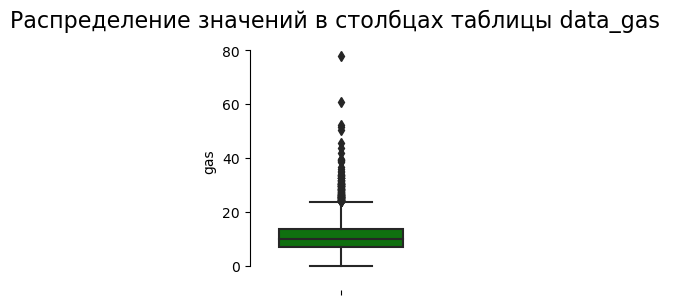

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(2,3))
sns.boxplot(y='gas', data=df, ax=ax, color='green')
sns.despine(offset=10, trim=True)
fig.suptitle('Распределение значений в столбцах таблицы data_gas ', y=1.0, fontsize=16);

Тут видно небольшой хвост, удалю несколько значений.

In [23]:
print('Итоговый запрос для данной таблицы:')
data_gas = '''
SELECT * FROM steel.data_gas
WHERE ("gas" <> 0.0)
'''
read_sql(data_gas)

Итоговый запрос для данной таблицы:


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


### data_temp

In [24]:
df = read_sql('SELECT * FROM steel.data_temp')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


In [25]:
df.isna().sum(), df.duplicated().sum()

(key               0
 MesaureTime       0
 Temperature    2901
 dtype: int64,
 0)

Очень много пропусков, скорее всего, будет лучшим решением - удалить их.

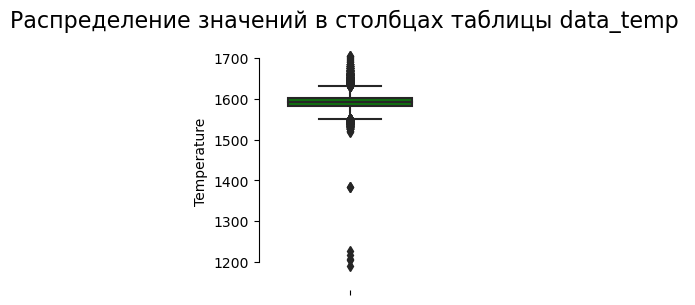

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(2,3))
sns.boxplot(y='Temperature', data=df, ax=ax, color='green')
sns.despine(offset=10, trim=True)
fig.suptitle('Распределение значений в столбцах таблицы data_temp ', y=1.0, fontsize=16);

In [27]:
df = df.dropna()
shape_first = df.shape[0]
df = df[(df['Temperature'] > 1500)]
print('Удалено строк:',shape_first - df.shape[0])

Удалено строк: 7


Заказчик предупредил, что температуры ниже 1500 - аномальные.

Temperature - целевой столбец. MeasureTime тоже необходимый. Нужно чтобы пропусков в них не было.

In [28]:
print('Итоговый запрос для данной таблицы:')
data_temp = '''
WITH LastTemperatures AS (
    SELECT
        key,
        MAX("MesaureTime") AS LastMeasureTime
    FROM
        steel.data_temp
    GROUP BY
        key
),
FirstTemperatures AS (
    SELECT
        key,
        MIN("MesaureTime") AS FirstMeasureTime
    FROM
        steel.data_temp
    GROUP BY
        key
),
LatestTemp AS (
    SELECT
        dt.key,
        dt."MesaureTime",
        dt."Temperature",
        lt.LastMeasureTime
    FROM
        steel.data_temp dt
    JOIN
        LastTemperatures lt
    ON
        dt.key = lt.key AND dt."MesaureTime" = lt.LastMeasureTime
    WHERE dt."Temperature" > 1500
),
EarliestTemp AS (
    SELECT
        dt.key,
        dt."MesaureTime",
        dt."Temperature" AS FirstTemperature,
        ft.FirstMeasureTime
    FROM
        steel.data_temp dt
    JOIN
        FirstTemperatures ft
    ON
        dt.key = ft.key AND dt."MesaureTime" = ft.FirstMeasureTime
    WHERE dt."Temperature" > 1500
)
SELECT key,AVG("lasttemperature") as "Temperature", AVG("firsttemperature") as "Temperature_first", AVG(COUNT) as heat_temp_times
FROM (SELECT *, COUNT("Temperature") OVER (PARTITION BY key)
FROM (
SELECT
    dt.key,
    dt."MesaureTime",
    dt."Temperature",
    lt."Temperature" AS LastTemperature,
    et.FirstTemperature
FROM
    steel.data_temp dt
LEFT JOIN
    LatestTemp lt ON dt.key = lt.key
LEFT JOIN
    EarliestTemp et ON dt.key = et.key
ORDER BY
    dt.key,
    dt."MesaureTime") as data_temp) as data_temp
WHERE (lasttemperature IS NOT NULL) AND (firsttemperature IS NOT NULL)
GROUP BY key
'''
read_sql(data_temp)

Итоговый запрос для данной таблицы:


,key,Temperature,Temperature_first,heat_temp_times
0,1,1613.0,1571.0,5.0
1,2,1602.0,1581.0,6.0
2,3,1599.0,1596.0,5.0
3,4,1625.0,1601.0,3.0
4,5,1602.0,1576.0,2.0
...,...,...,...,...
2468,2495,1591.0,1570.0,3.0
2469,2496,1591.0,1554.0,4.0
2470,2497,1589.0,1571.0,2.0
2471,2498,1594.0,1591.0,5.0


### data_wire

In [29]:
df = read_sql('SELECT * FROM steel.data_wire')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


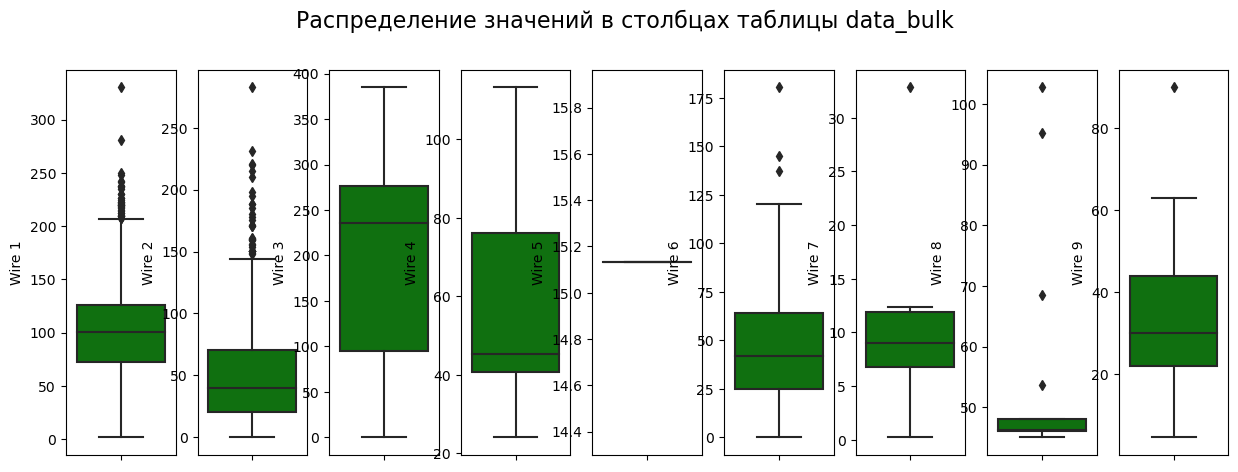

In [30]:
fig, ax = plt.subplots(1, 9, figsize=(15, 5))
columns = df.columns[1:10]
for i in range(1,10):
    column = columns[i-1]
    sns.boxplot(y=f'{column}', data=df, ax=ax[i-1], color='green')
fig.suptitle('Распределение значений в столбцах таблицы data_bulk ', y=1.0, fontsize=16);

In [31]:
df.corr() > 0.7

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,True,False,False,False,False,False,False,False,False,False
Wire 1,False,True,False,True,False,False,False,False,False,False
Wire 2,False,False,True,False,False,False,False,False,False,False
Wire 3,False,True,False,True,False,False,False,False,False,False
Wire 4,False,False,False,False,True,False,False,False,False,False
Wire 5,False,False,False,False,False,False,False,False,False,False
Wire 6,False,False,False,False,False,False,True,False,False,False
Wire 7,False,False,False,False,False,False,False,True,False,False
Wire 8,False,False,False,False,False,False,False,False,True,False
Wire 9,False,False,False,False,False,False,False,False,False,True


In [32]:
print('Итоговый запрос для данной таблицы:')
data_wire='''
SELECT key,
        COALESCE("Wire 1", 0) as "Wire 1",
        COALESCE("Wire 2", 0) as "Wire 2",
        COALESCE("Wire 3", 0) as "Wire 3",
        COALESCE("Wire 4", 0) as "Wire 4",
        COALESCE("Wire 5", 0) as "Wire 5",
        COALESCE("Wire 6", 0) as "Wire 6",
        COALESCE("Wire 7", 0) as "Wire 7",
        COALESCE("Wire 8", 0) as "Wire 8",
        COALESCE("Wire 9", 0) as "Wire 9"
FROM steel.data_wire
WHERE (
("Wire 1" <> 0.0) OR ("Wire 2" <> 0.0) OR ("Wire 3" <> 0.0) OR ("Wire 4" <> 0.0) OR ("Wire 5" <> 0.0) OR 
("Wire 6" <> 0.0) OR ("Wire 7" <> 0.0) OR ("Wire 8" <> 0.0) OR ("Wire 9" <> 0.0))
'''
read_sql(data_wire)

Итоговый запрос для данной таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### data_wire_time

In [33]:
df = read_sql('SELECT * FROM steel.data_wire_time')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


In [34]:
print('Итоговый запрос для данной таблицы:')
data_wire_time= '''
SELECT key,
        COALESCE("Wire 1", '00:00:00') as "Wire 1",
        COALESCE("Wire 2", '00:00:00') as "Wire 2",
        COALESCE("Wire 3", '00:00:00') as "Wire 3",
        COALESCE("Wire 4", '00:00:00') as "Wire 4",
        COALESCE("Wire 5", '00:00:00') as "Wire 5",
        COALESCE("Wire 6", '00:00:00') as "Wire 6",
        COALESCE("Wire 7", '00:00:00') as "Wire 7",
        COALESCE("Wire 8", '00:00:00') as "Wire 8",
        COALESCE("Wire 9", '00:00:00') as "Wire 9"
FROM steel.data_wire_time
'''
read_sql(data_wire_time)

Итоговый запрос для данной таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
1,2,11:46:10,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
2,3,12:13:47,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
3,4,12:48:05,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
4,5,13:18:15,13:32:06,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
...,...,...,...,...,...,...,...,...,...,...
3076,3237,22:50:20,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
3077,3238,23:38:24,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
3078,3239,01:50:43,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
3079,3240,03:12:02,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00


**Вывод:**
- Были удалены выбросы.
- Добавлены новые признаки.
- Удалены ненужные признаки.
- Некоторые признаки приведены к нужному формату.

### Объединение таблиц

In [35]:
data = f'''
SELECT data_arc.key as index, *
FROM ({data_arc}) as data_arc
INNER JOIN ({data_bulk}) as data_bulk ON data_arc.key = data_bulk.key
INNER JOIN ({data_gas}) as data_gas ON data_arc.key = data_gas.key
INNER JOIN ({data_temp}) as data_temp ON data_arc.key = data_temp.key
INNER JOIN ({data_wire}) as data_wire ON data_arc.key = data_wire.key
'''
data = read_sql(data)

In [36]:
data = data.drop(['key', 'index'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   heating_time       2325 non-null   object 
 1   Power              2325 non-null   float64
 2   heat_times         2325 non-null   float64
 3   Bulk 1             2325 non-null   float64
 4   Bulk 3             2325 non-null   float64
 5   Bulk 4             2325 non-null   float64
 6   Bulk 5             2325 non-null   float64
 7   Bulk 6             2325 non-null   float64
 8   Bulk 7             2325 non-null   float64
 9   Bulk 8             2325 non-null   float64
 10  Bulk 9             2325 non-null   float64
 11  Bulk 10            2325 non-null   float64
 12  Bulk 11            2325 non-null   float64
 13  Bulk 12            2325 non-null   float64
 14  Bulk 13            2325 non-null   float64
 15  Bulk 14            2325 non-null   float64
 16  Bulk 15            2325 

In [37]:
data['heating_time'] = data['heating_time'].apply(lambda x: x.strftime('%H:%M:%S'))

In [38]:
data['heating_time'] = pd.to_datetime(data['heating_time'], format = '%H:%M:%S')

In [39]:
data.loc[data['heating_time'] <= '1900-01-01 00:01:00', 'heating_minutes'] = 1
data.loc[(data['heating_time'] <= '1900-01-01 00:02:00') & (data['heating_time'] > '1900-01-01 00:01:00'),
         'heating_minutes'] = 2
data.loc[(data['heating_time'] <= '1900-01-01 00:03:00') & (data['heating_time'] > '1900-01-01 00:02:00'),
         'heating_minutes'] = 3
data.loc[(data['heating_time'] <= '1900-01-01 00:04:00') & (data['heating_time'] > '1900-01-01 00:03:00'),
         'heating_minutes'] = 4
data.loc[(data['heating_time'] <= '1900-01-01 00:05:00') & (data['heating_time'] > '1900-01-01 00:04:00'),
         'heating_minutes'] = 5

In [40]:
data.isna().sum().sum()
data = data.dropna()
data = data.drop('heating_time', axis = 1)

In [41]:
data['heating_minutes'].value_counts()

heating_minutes
3.0    1161
4.0     749
2.0     251
5.0     147
1.0       4
Name: count, dtype: int64

In [42]:
#data['time_temp'] = data['time_temp'].dt.total_seconds() / 60
display(data.head())
display(data.tail())

,Power,heat_times,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Temperature,Temperature_first,heat_temp_times,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,heating_minutes
0,4.878147,5.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1613.0,1571.0,5.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,3.052598,4.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1602.0,1581.0,6.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,2.525882,5.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1599.0,1596.0,5.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,3.209250,4.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1625.0,1601.0,3.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,3.347173,4.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1602.0,1576.0,2.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


,Power,heat_times,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Temperature,Temperature_first,heat_temp_times,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,heating_minutes
2320,3.210690,4.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1591.0,1570.0,3.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2321,4.203064,6.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1591.0,1554.0,4.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2322,2.212379,3.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,1589.0,1571.0,2.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2323,3.408725,5.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1594.0,1591.0,5.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2324,4.098431,4.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,11.336151,1603.0,1569.0,3.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


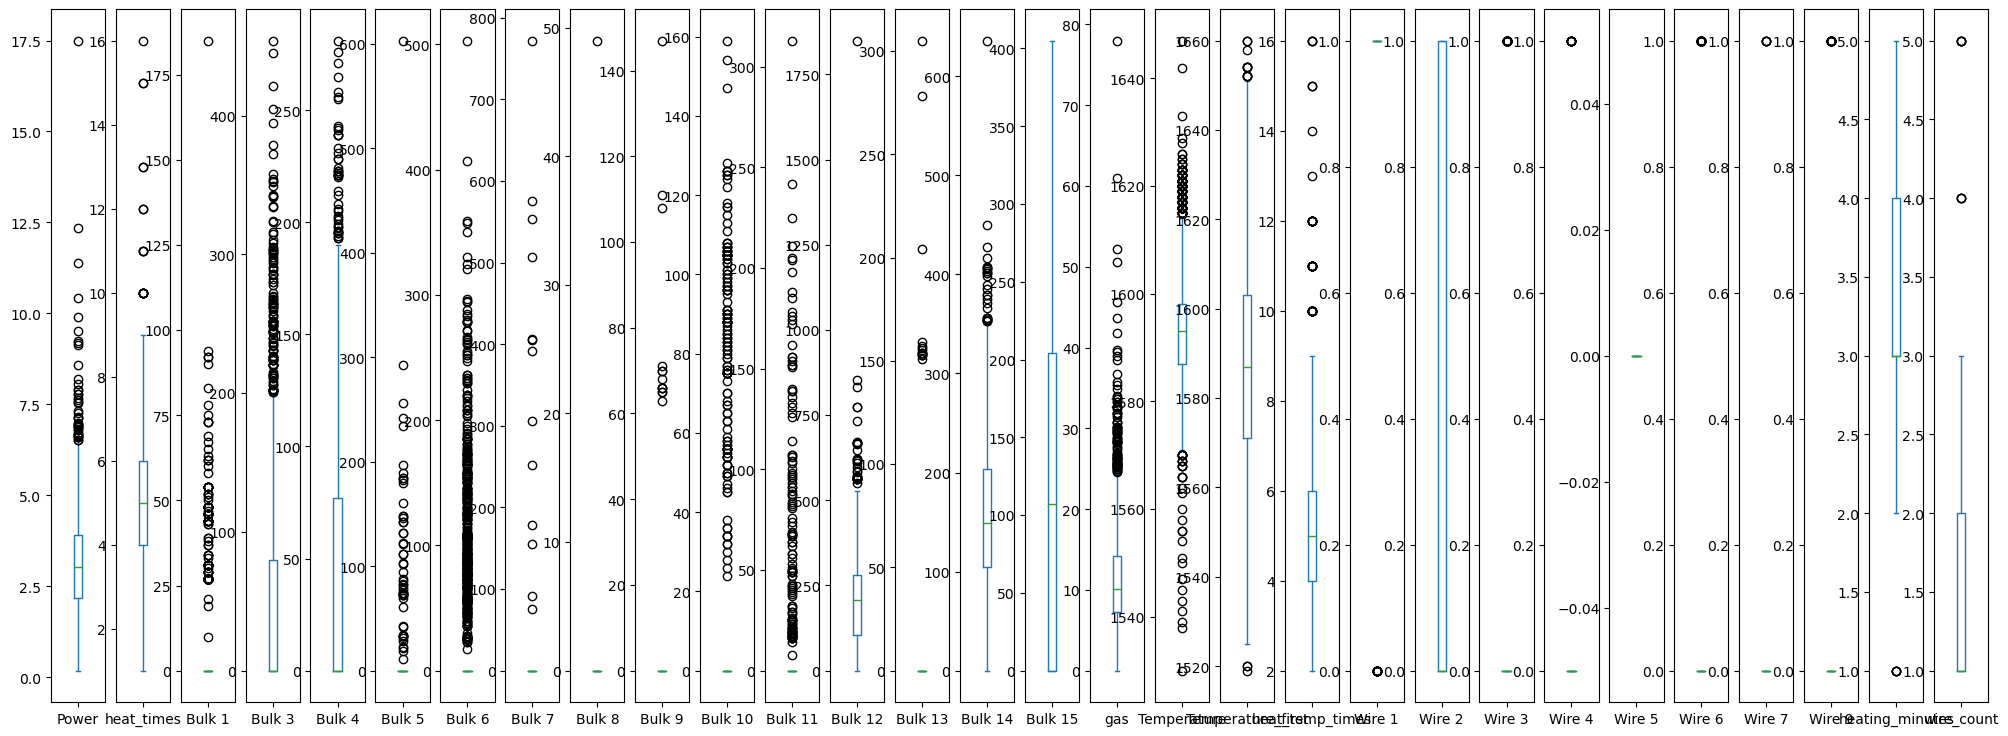

In [62]:
data.plot(kind = 'box', subplots = True, figsize = (25,9));

### Correlation

In [44]:
data.corr()

,Power,heat_times,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Temperature,Temperature_first,heat_temp_times,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,heating_minutes
Power,1.000000,0.766743,0.086661,0.115330,-0.029365,0.007036,0.150066,0.075153,-0.011387,0.024174,0.005795,0.066858,0.476298,0.123519,0.462812,0.333520,0.373849,0.253218,-0.431308,0.355843,0.056592,0.057890,0.036331,0.048196,NaN,0.054132,0.019896,0.029964,-0.015886,0.536122
heat_times,0.766743,1.000000,0.100581,0.107724,-0.001326,0.074791,0.152441,0.152839,-0.009107,0.038062,0.011616,0.066021,0.312639,0.117879,0.337886,0.175896,0.404224,0.160802,-0.182041,0.500146,0.141504,0.076474,0.054966,0.113840,NaN,0.053098,0.073838,0.043762,-0.025099,0.014152
Bulk 1,0.086661,0.100581,1.000000,-0.011402,0.039533,0.060654,-0.002471,0.237951,-0.005735,-0.019791,-0.023179,-0.036841,0.326481,-0.010285,0.208600,-0.002928,0.234230,-0.068593,0.077158,0.117661,0.011333,-0.008805,0.020372,0.146764,NaN,0.149053,0.083705,-0.019570,0.011131,0.056315
Bulk 3,0.115330,0.107724,-0.011402,1.000000,-0.296168,-0.006918,0.066319,-0.033633,0.020868,0.011312,-0.085654,-0.004455,0.020982,-0.013491,0.012785,-0.012832,0.060250,-0.031412,-0.109341,0.023022,0.038393,0.094402,0.005702,-0.040699,NaN,0.007041,-0.019531,0.004802,0.004559,0.031083
Bulk 4,-0.029365,-0.001326,0.039533,-0.296168,1.000000,0.028540,-0.251006,0.046104,-0.013217,-0.002894,-0.084873,-0.117534,0.105593,0.003278,-0.091228,0.103686,0.017565,0.177372,0.161992,0.011277,0.293247,-0.268310,-0.039268,0.034592,NaN,-0.011370,0.033971,0.007913,-0.058272,-0.057011
Bulk 5,0.007036,0.074791,0.060654,-0.006918,0.028540,1.000000,-0.021866,0.288300,-0.002461,-0.008494,-0.028697,-0.015530,-0.072651,-0.008907,-0.065806,-0.067294,0.087032,-0.029224,0.078500,0.081756,-0.013612,-0.014143,0.070823,0.262725,NaN,0.204741,0.172123,-0.008399,-0.010897,-0.050082
Bulk 6,0.150066,0.152441,-0.002471,0.066319,-0.251006,-0.021866,1.000000,-0.025173,-0.008360,-0.028849,-0.097473,0.199036,-0.116045,0.042917,0.173159,-0.112617,0.138488,-0.174692,-0.126965,0.106265,-0.234435,0.206770,-0.046661,-0.025994,NaN,-0.020232,-0.012475,-0.028527,-0.013326,0.057744
Bulk 7,0.075153,0.152839,0.237951,-0.033633,0.046104,0.288300,-0.025173,1.000000,-0.001365,-0.004710,-0.015912,-0.004705,-0.017524,-0.004939,-0.076511,-0.090351,0.198697,-0.104375,0.088773,0.149673,-0.144293,-0.000816,0.156580,0.740564,NaN,0.456075,0.372242,-0.004657,-0.006042,-0.065351
Bulk 8,-0.011387,-0.009107,-0.005735,0.020868,-0.013217,-0.002461,-0.008360,-0.001365,1.000000,0.488390,-0.005045,-0.003863,-0.027591,-0.001566,-0.039282,-0.029461,0.004127,-0.025775,-0.011922,-0.011453,0.034890,0.018875,-0.002418,-0.001346,NaN,-0.002351,-0.000646,0.321035,-0.001916,-0.009272
Bulk 9,0.024174,0.038062,-0.019791,0.011312,-0.002894,-0.008494,-0.028849,-0.004710,0.488390,1.000000,-0.017412,-0.013332,-0.057734,-0.005404,0.039237,-0.093763,0.116789,-0.020508,-0.021421,-0.015872,0.022742,0.066605,-0.008343,-0.004643,NaN,-0.008115,-0.002228,0.974968,-0.006612,-0.020521


In [45]:
data.phik_matrix(verbose=False) > 0.9

/Users/artemmm/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable Wire 5 for analysis 1. Dropping this column
  warnings.warn(


,Power,heat_times,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Temperature,Temperature_first,heat_temp_times,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,heating_minutes
Power,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
heat_times,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 5,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 6,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bulk 7,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
Bulk 8,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
Bulk 9,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


Wire 8 высокая корреляция с Bulk 8 и Bulk 9. Удалю.

In [46]:
data = data.drop(['Wire 8'], axis = 1)

In [47]:
data.loc[0,:]

Power                   4.878147
heat_times              5.000000
Bulk 1                  0.000000
Bulk 3                  0.000000
Bulk 4                 43.000000
Bulk 5                  0.000000
Bulk 6                  0.000000
Bulk 7                  0.000000
Bulk 8                  0.000000
Bulk 9                  0.000000
Bulk 10                 0.000000
Bulk 11                 0.000000
Bulk 12               206.000000
Bulk 13                 0.000000
Bulk 14               150.000000
Bulk 15               154.000000
gas                    29.749986
Temperature          1613.000000
Temperature_first    1571.000000
heat_temp_times         5.000000
Wire 1                 60.059998
Wire 2                  0.000000
Wire 3                  0.000000
Wire 4                  0.000000
Wire 5                  0.000000
Wire 6                  0.000000
Wire 7                  0.000000
Wire 9                  0.000000
heating_minutes         4.000000
Name: 0, dtype: float64

### Синтезирование признаков

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2312 entries, 0 to 2324
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Power              2312 non-null   float64
 1   heat_times         2312 non-null   float64
 2   Bulk 1             2312 non-null   float64
 3   Bulk 3             2312 non-null   float64
 4   Bulk 4             2312 non-null   float64
 5   Bulk 5             2312 non-null   float64
 6   Bulk 6             2312 non-null   float64
 7   Bulk 7             2312 non-null   float64
 8   Bulk 8             2312 non-null   float64
 9   Bulk 9             2312 non-null   float64
 10  Bulk 10            2312 non-null   float64
 11  Bulk 11            2312 non-null   float64
 12  Bulk 12            2312 non-null   float64
 13  Bulk 13            2312 non-null   float64
 14  Bulk 14            2312 non-null   float64
 15  Bulk 15            2312 non-null   float64
 16  gas                2312 non-n

In [49]:
wire_list = ['Wire 1','Wire 2','Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 9']
data[wire_list] = data[wire_list].applymap(lambda x: 0 if x == 0.0 else 1)
data['wire_count'] = data[wire_list].sum(axis=1)

## Деление на выборки

In [50]:
train, test = train_test_split(data, test_size = 0.25, random_state = RANDOMSTATE)
x_train = train.drop('Temperature', axis = 1)
y_train = train['Temperature']
x_test = test.drop('Temperature', axis = 1)
y_test = test['Temperature']

## Удаление выбросов

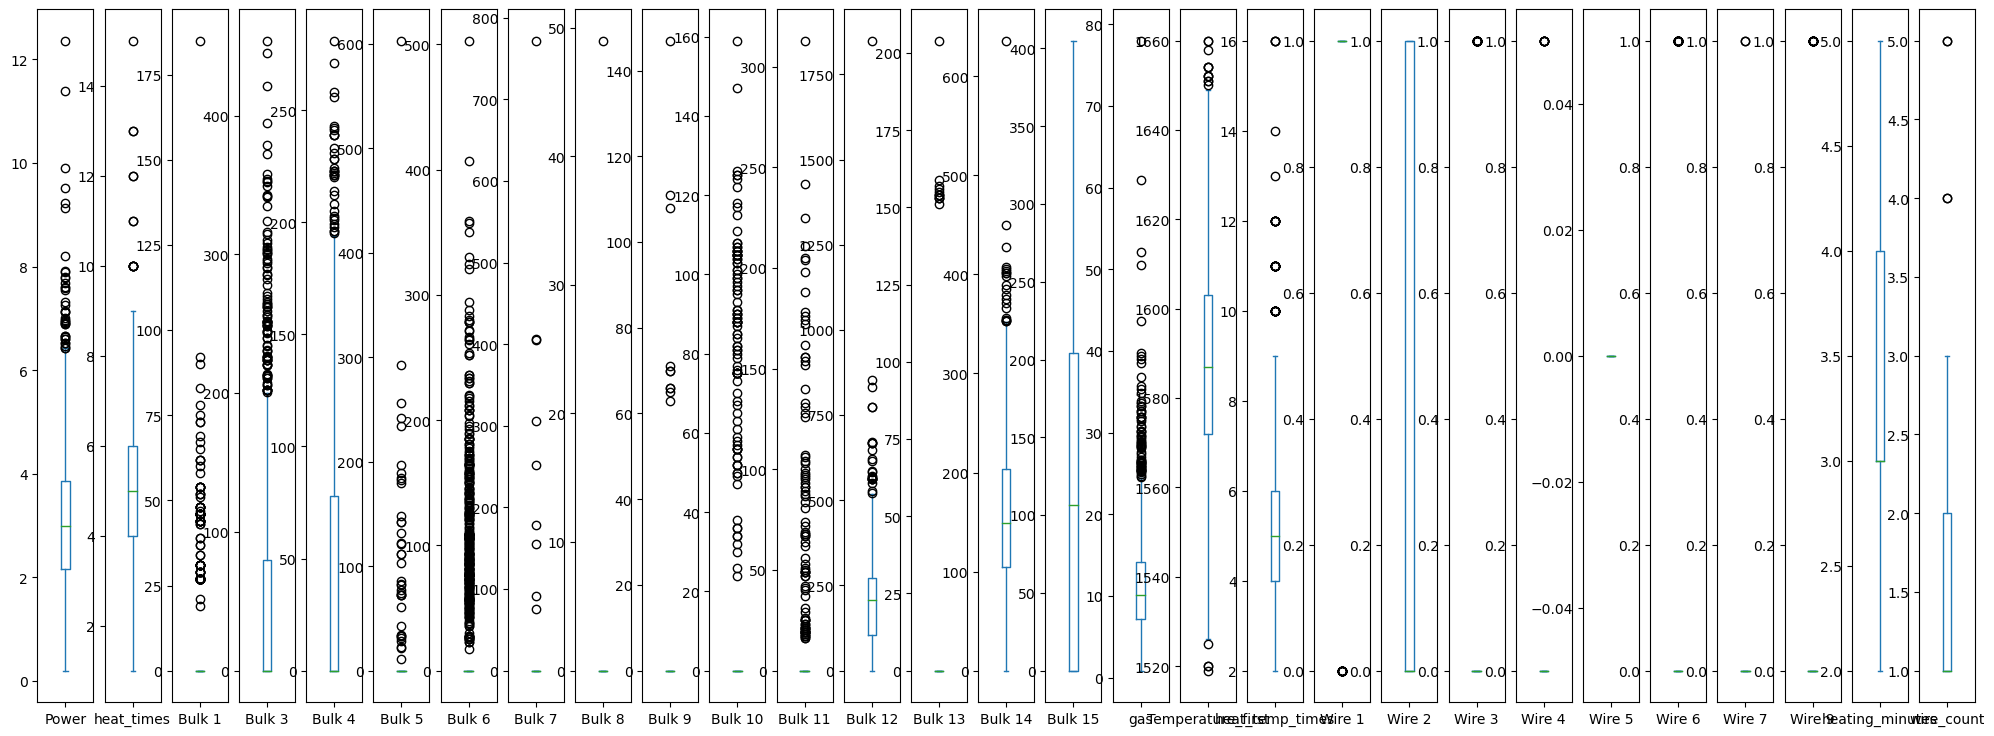

In [51]:
x_train.plot(kind = 'box', subplots = True, figsize = (25,9));

In [52]:
indices = x_train[(x_train['Bulk 5'] < 500) &
                           (x_train['Bulk 1'] < 175) &
                           (x_train['gas'] != 0) & 
                           (x_train['gas'] < 30) &
                           (x_train['Wire 7'] < 15)].index

x_train = x_train.loc[indices]
y_train = y_train.loc[indices]

In [63]:
x_train.shape

(1703, 29)

Требование заказчика удовлетворяется.

## Обучение моделей

### RandomForest

In [53]:
best_mae = 20
for depth in [5,9,12]:
    for est in [30,60,90]:
        model_rf = RandomForestRegressor(n_estimators = est, max_depth = depth)
        model_rf.fit(x_train,y_train)
        predict = model_rf.predict(x_test)
        mae = mean_absolute_error(predict, y_test)
        if mae < best_mae:
            best_est = est
            best_depth = depth
            best_mae = mae
print(best_mae, best_est, best_depth)

6.099088267704559 90 9


### CatBoost

In [54]:
model_cb = CatBoostRegressor(verbose = False)
model_cb.fit(x_train,y_train)
predict = model_cb.predict(x_test)
print(mean_absolute_error(predict, y_test))
print(model_cb.get_params())

5.951829031828125
{'loss_function': 'RMSE', 'verbose': False}


In [55]:
import optuna
def objective_CBR(trial, X_train=x_train.values, y_train=y_train.values, X_val=x_test.values, y_val=y_test.values):
    
    params = {'max_depth': trial.suggest_int('max_depth', 3, 5,7),
              'learning_rate': trial.suggest_float('learning_rate', 0.087, 0.089), 
              'n_estimators': trial.suggest_int('n_estimators', 1000, 1100), 
              'loss_function': 'RMSE',
              'eval_metric': 'MAE'
             }
    
    model = CatBoostRegressor(**params, random_state=RANDOMSTATE)
                               
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=100,
              verbose=False)
    
    return model.get_best_score()['validation']['MAE']
study_cbr = optuna.create_study(direction = 'minimize', study_name='CatBoost')
study_cbr.optimize(objective_CBR, n_trials = 20)

[I 2024-05-21 13:11:52,687] A new study created in memory with name: CatBoost
/var/folders/yr/04d7xw_d5610csnyxxj8t5p40000gn/T/ipykernel_3891/268385486.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  params = {'max_depth': trial.suggest_int('max_depth', 3, 5,7),
/Users/artemmm/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(
[I 2024-05-21 13:11:52,916] Trial 0 finished with value: 5.878334014203939 and parameters: {'max_depth': 3, 'learning_rate': 0.08856984678180138, 'n_estimators': 1023}. Best is trial 0 with value: 5.878334014203939.
[I 2024-05-21 13:11:53,087] Trial 1 finished with value: 5.916040117903888 and parameters: {'max_depth': 3, 'learning_rate': 0.08748011511189563, 'n_estimators': 1097}. Best is trial 0 with value: 5.8

### Нейросеть

In [56]:
scaler = StandardScaler()
x_train_nn = scaler.fit_transform(x_train)
x_test_nn = scaler.transform(x_test)
x_train_nn = torch.FloatTensor(x_train_nn)
x_test_nn = torch.FloatTensor(x_test_nn)
y_train_nn = torch.FloatTensor(y_train.values).view(-1,1)
y_test_nn = torch.FloatTensor(y_test.values).view(-1,1)

In [ ]:
progress_bar = widgets.FloatProgress(
    value=0.0,
    min=0.0,
    max=1.0,
    description='Progress:',
    style={'bar_color': 'lightblue'}
)
display(progress_bar)

n_in_neurons = 29
n_hidden_neurons_1 = 5000
n_hidden_neurons_2 = 2500
n_out_neurons = 1

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2), 
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

optimizer = torch.optim.Adam(net.parameters())
loss = nn.L1Loss()

num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(x_train_nn) 
    loss_value = loss(preds, y_train_nn)
    loss_value.backward()
    optimizer.step()
    if epoch % 1 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(x_test_nn)
        train_preds = net.forward(x_train_nn)
        test_preds_np = test_preds.detach().numpy()
        train_preds_np = train_preds.detach().numpy()
        MAE = mean_absolute_error(y_test_nn.numpy(), test_preds_np)
        MAE_train = mean_absolute_error(y_train_nn.numpy(), train_preds_np)
        if epoch % 1 == 0: 
            print('epoch:', epoch,'mae_tr:',MAE_train, 'mae_test:',MAE)
    time.sleep(0.0)  
    progress_bar.value = (epoch + 1) / num_epochs
base_rmse = MAE
progress_bar.close()

FloatProgress(value=0.0, description='Progress:', max=1.0, style=ProgressStyle(bar_color='lightblue'))

epoch: 0 mae_tr: 1593.0602 mae_test: 1593.3982
epoch: 1 mae_tr: 1572.4739 mae_test: 1572.1227
epoch: 2 mae_tr: 1547.4647 mae_test: 1546.274
epoch: 3 mae_tr: 1517.4905 mae_test: 1515.2903
epoch: 4 mae_tr: 1481.8309 mae_test: 1478.4258
epoch: 5 mae_tr: 1440.2449 mae_test: 1436.7913
epoch: 6 mae_tr: 1393.3483 mae_test: 1390.5941
epoch: 7 mae_tr: 1339.8978 mae_test: 1340.0989
epoch: 8 mae_tr: 1279.1678 mae_test: 1284.5457
epoch: 9 mae_tr: 1211.4491 mae_test: 1223.8944
epoch: 10 mae_tr: 1136.7341 mae_test: 1155.6866
epoch: 11 mae_tr: 1055.6196 mae_test: 1079.4115
epoch: 12 mae_tr: 971.7076 mae_test: 996.1959
epoch: 13 mae_tr: 891.495 mae_test: 911.76935
epoch: 14 mae_tr: 810.19556 mae_test: 826.8548
epoch: 15 mae_tr: 729.6867 mae_test: 742.1023
epoch: 16 mae_tr: 650.0031 mae_test: 657.8052
epoch: 17 mae_tr: 577.22064 mae_test: 582.6948
epoch: 18 mae_tr: 522.7337 mae_test: 525.1057
epoch: 19 mae_tr: 492.09396 mae_test: 498.03113
epoch: 20 mae_tr: 486.2899 mae_test: 498.11667
epoch: 21 mae_tr

**Вывод:**
Модель CatBoost, на которой подбор гиперпараметров проводился через Optuna показала лучшие результаты, по сравнению с RFR и нейросетью.

### Тестирование модели

In [58]:
best_params = study_cbr.best_trial.params
best_model = CatBoostRegressor(**best_params, loss_function='RMSE', eval_metric='MAE', random_state=RANDOMSTATE)
best_model.fit(x_train.values, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=False)
y_pred = best_model.predict(x_test.values)
mae = mean_absolute_error(y_test.values, y_pred)
print(mae)

5.8783350142039925


In [68]:
DummyModel_mean = DummyRegressor(strategy='mean')
DummyModel_median = DummyRegressor(strategy='median')

for st in ['mean', 'median']:
    DR = DummyRegressor(strategy = st)
    DR.fit(x_train, y_train)
    print('MAE DM:', mean_absolute_error(y_test, DR.predict(x_test)))

MAE DM: 8.266250073653863
MAE DM: 8.264705882352942


Вывод: CatBoost справляется лучше, чем константная модель.

Порог в 6.9 МАЕ модель прошла. Теперь необходимо проанализировать важность признаков.

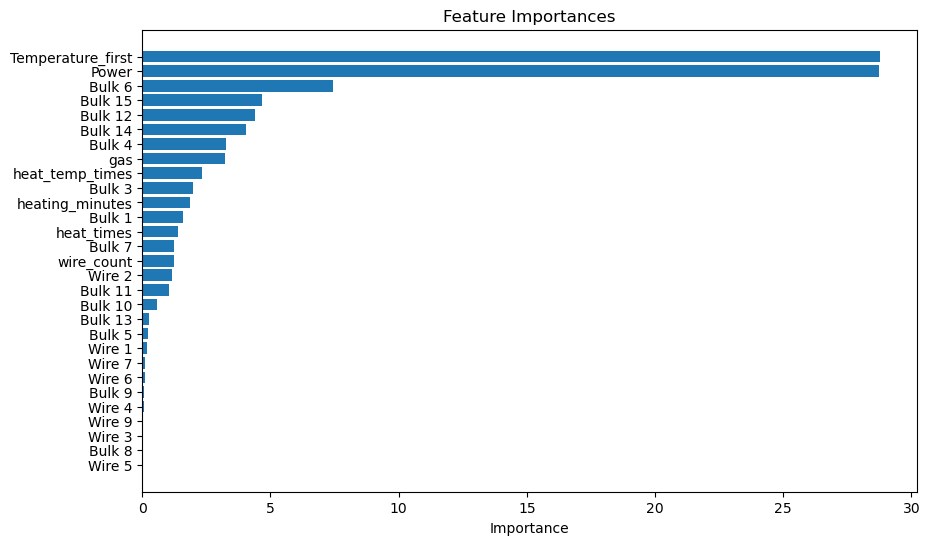

In [59]:
feature_importances = best_model.get_feature_importance(Pool(x_train, label=y_train))
feature_names = x_train.columns if hasattr(x_train, 'columns') else [f'Feature {i}' for i in range(x_train.shape[1])]
plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importances)
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

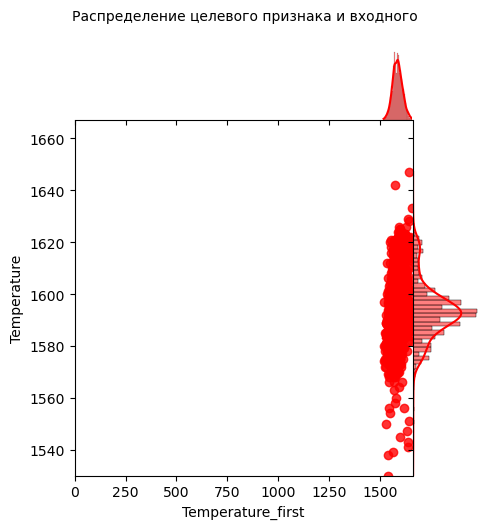

In [60]:
sns.jointplot(x=data['Temperature_first'],
              y=data['Temperature'],
              height=5,
              ratio=5,
              space=0.01,
              xlim=[0, data['Temperature_first'].max() + 0.5],
              ylim=[data['Temperature'].min(), data['Temperature'].max() +20],
              kind='reg',
              color='r')
plt.suptitle('Распределение целевого признака и входного',
             y = 1.05, fontsize = 10)
plt.show()

**Вывод: Виднеется небольшой наклон в правую сторону, это сведетельствует о наличии некоторой зависимости между признаками.**

## Итог по проекту:
- EDA проведен.
- Таблицы объединины, разделены.
- Модель RFR, CatBoost, нейронная сеть обучены.
- Признаки масштабированы.
- Выбрана лучшая модель.
- Проведено тестирование лучшей модели.